### This notebook is designed to make a Dataframe with rear events and trajectories surroundin it 
Make one large data frame with all rears. 
Then it shoud calculate the dxiaplcement between X and y and potl it againt Z

# TODO: 

make an average displacement plot 

Add if rear is in invisble condition or visible 

REFACTOR...


In [244]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums
import numpy as np
import scipy.stats
import os
import fnmatch

#### imports for a sample session

In [245]:
root = '//10.153.170.3/storage2/fabian/data/project/CALIBRATION/'
root3 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
root4 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS04/'
figures = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Figures/'
animal = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'

#need to correct this and uncomment all esle

laptop_root = 'C:/Users/Fabian/Desktop/Rearing_analysis/Data/FS10/BPositions_FS10_20211006-154014/'
FS03_position=pd.read_csv(laptop_root+'position_20211006-154014.txt',sep=" ", header=None)
FS03_beacon=pd.read_csv(laptop_root+'beacons_20211006-154014.txt',sep=" ", header=None)
FS03_metadata= pd.read_csv(laptop_root+'metadata_20211006-154014.txt',sep=" : ", header=None, index_col=0).T

    

# FS03_position= pd.read_csv(root3+'position_20210312-172823.txt',sep=" ", header=None)
# FS04_position = pd.read_csv(root4+'position_20210322-202458.txt',sep=" ", header=None)

# FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
# FS04_beacon = pd.read_csv(root4+'beacons_20210322-202458.txt',sep=" ", header=None)

# FS03_metadata = pd.read_csv(root3+'metadata_20210312-172823.txt',sep=" : ", header=None, index_col=0).T

# pd.options.display.float_format = '{:.3f}'.format
# FS03_metadata
# invisible_time = eval(FS03_metadata['invisible_time'].item())
# invisible_time

C:\Users\Fabian\Anaconda3\envs\imaginganalysis\lib\site-packages\ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  del sys.path[0]


In [246]:
FS03_position.head()

,0,1,2,3,4,5,6,7,8,9
0,1.633528e+09,-0.398011,0.763059,1.815725,24.933073,160.919337,-38.705788,21416965,5.033776e+06,0.0
1,1.633528e+09,-0.396177,0.761636,1.816663,24.632273,158.630123,-36.643266,21416967,5.033776e+06,0.0
2,1.633528e+09,-0.397547,0.761200,1.815822,25.804681,157.259466,-36.302062,21416969,5.033776e+06,0.0
3,1.633528e+09,-0.398443,0.760693,1.816566,25.177920,156.345717,-34.712163,21416971,5.033776e+06,0.0
4,1.633528e+09,-0.399465,0.760649,1.816875,25.392948,155.845626,-33.116751,21416973,5.033776e+06,0.0


### Rotation format - dont care about rotation if the cut off on the walls are set correctly. 

In [247]:
##(xcosθ−ysinθ ,xsinθ+ycosθ).
def rotation_correction_points(position_data,alpha=1.7):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data[1] = position_data[1] * np.cos(alpha) - position_data[3] * np.sin(alpha)
    rot_position_data[3] = position_data[1] * np.sin(alpha) + position_data[3] * np.cos(alpha)
    return rot_position_data
def rotation_correction_beacons(position_data,alpha=-5):
    alpha = (alpha) * np.pi / 180
    rot_position_data = position_data
    rot_position_data["BeaconX"] = position_data["BeaconX"] * np.cos(alpha) - position_data["BeaconY"] * np.sin(alpha)
    rot_position_data["BeaconY"] = position_data["BeaconX"] * np.sin(alpha) + position_data["BeaconY"] * np.cos(alpha)
    return rot_position_data


### Steps to do to the data: 
    
    0th - get proper vut offs for borderless arena 
    A.Make rearign file >.62 where time XYZ of detected rear 
    B. Use those indexes from rearign file to index into the rearign and generate rearign trajectories before and after. 
    C. Plot trajectories.
    D. Generate histogram of how long a rear would last. - Just find index of last and first and get the difference between the times 
    C. Index into rearign which are only within the arena 
    D. Index into only those that have an invisible condition 
    E. Calculate how far from beacon that rear is - plot rears only within 0-30 cm away from beacon 
    D. Calculate the X and Y displacement. 
    
 

### Borders of arena - hardcoded from calibration file 

In [279]:
cut = 0 # keeping the cut where rectangle of arena ends
X_cut_min = -.59
Y_cut_max = 1.61
X_cut_max = .12
Y_cut_min = .00
print("area %s M*2" %((X_cut_max-X_cut_min)*(Y_cut_max-Y_cut_min))) 
#Translations
x_max, x_min = 0.12, -0.59
x_offset = x_max - (x_max - x_min)/2
y_max, y_min = 1.61,  0
y_offset = y_max - (y_max - y_min)/2
print(x_offset,y_offset)
xcut_offset=-.24
ycut_offset=-.8
#alpha
rotation= 1.7

area 1.1431 M*2
-0.235 0.805


### Show Output from Arena with added beacons - They were a bit off to begin with and shoudl be so for calculations

In [280]:
# CALIB1 = pd.read_csv(root+'BPositions_CALIBRATION_20210610-111132/position_20210610-111132.txt',sep=" ", header=None)    
# CALIB1[1]= CALIB1[1]-xcut_offset
# CALIB1[3]= CALIB1[3]+ycut_offset
# rot_position_data=  rotation_correction_points(CALIB1,alpha=1.7)
# fig, ax1 = plt.subplots(1, 1, sharex=True,dpi=400, sharey=True)
# fig.suptitle("Calibration")
# ax1.set_title('After translation, rotation and beacons ')
# rearing3 = pd.read_excel(processed +'FS11_rears_new.xlsx')
# rearing3 = rotation_correction_beacons(rearing3,alpha=-5)
# ax1.plot(rot_position_data[1],rot_position_data[3])
# ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_max-cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
# ax1.plot([(X_cut_min+cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
# ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_max-cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_max-cut)+ycut_offset] ,'r-')
# ax1.plot([(X_cut_max-cut)-xcut_offset,(X_cut_min+cut)-xcut_offset],[(Y_cut_min+cut)+ycut_offset,(Y_cut_min+cut)+ycut_offset] ,'r-')
# ax1.scatter(rearing3["BeaconX"],rearing3["BeaconY"],s=1,marker='*', facecolors='none', edgecolors='green')
# plt.gca().set_aspect('equal')

### A. get secific point per rear event in center of arena

In [281]:
def Z_period_dynamics(positions):
    """get every rear event in center of arena
    
    If animal gets above .62 detect it as one until below again
    
    PARAMS
    ------------
    positions : DataFrame 
    
    Returns
    ------------
    Data Frame with all rears position (begining of rear) and time. 

    """
    high =0 
    low = 0
    switch = 0 
    last = .60
    high_points=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
                high_points.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last = height
        count +=1
    return pd.DataFrame(high_points)
Z_points= Z_period_dynamics(FS03_position)
Z_points

,0,1,2,3
0,1.633528e+09,-0.583590,0.039560,0.628378
1,1.633528e+09,0.013989,0.017842,0.621344
2,1.633528e+09,0.093031,1.590989,0.626044
3,1.633528e+09,-0.525802,0.066101,0.620354
4,1.633528e+09,0.022690,0.059185,0.622090
...,...,...,...,...
106,1.633529e+09,-0.419253,0.438271,0.622355
107,1.633529e+09,-0.576481,0.126243,0.622173
108,1.633529e+09,-0.407815,0.239294,0.623147
109,1.633529e+09,-0.493944,0.051995,0.623714


In [282]:
window_beg=20
window_end=120

def make_rear_dyn(position_data, rear_time ,metadata, window_beg=window_beg,window_end=window_end,in_arena=True):
    '''
    Return
    trial_list: list of numpy arrays position data [time, x, y, z] 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible
    before_beacon: list of positions before the first beacon appears
    '''

    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time.iloc[:, -2:]
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time.iloc[:, 0]
    ]

    trial_list.append(position_data[:rear_time_idx[0]])
    for i in range(len(rear_time_idx)):
        if i != len(rear_time_idx) - 1:
            trial = position_data[
                rear_time_idx[i]-window_beg:rear_time_idx[i]+window_end]
        else:
            trial = position_data[rear_time_idx[i]:]
        trial_list.append(trial)
    before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=make_rear_dyn(position_data =FS03_position , 
                                                               rear_time= Z_points, metadata=FS03_metadata,window_beg=window_beg,window_end=window_end )

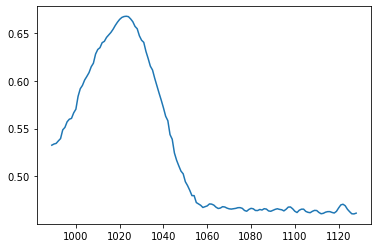

In [283]:
plt.plot(trial_list[1][2])  

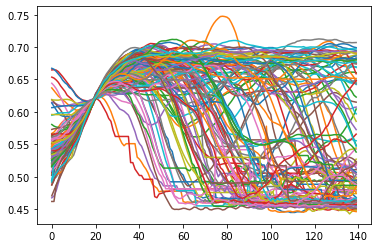

In [284]:
#print (len(trial_list[5]))
window= window_beg+window_end

#print(trial_list)
for trial in trial_list:
    #print (len(trial))
    if len(trial)==window:
        trial_len=range(window) 
        plt.plot(trial_len, trial[2],)

### Get only times when above.62 

### Create a histogram for each rear. - probably need to gen. an index where it ends nd starts 

In [290]:
def Z_period_dynamics_beg_end(positions):
    """get every rear event in center of arena
    
    If animal gets above .62 detect it as one until below again
    
    PARAMS
    ------------
    positions : DataFrame 
    
    Returns
    ------------
    Data Frame with all rears position (begining of rear) and time. 

    """
    high =0 
    low = 0
    switch = 0 
    last = .60
    last2=.60
    high_points=[]
    high_points_end=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            #if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
            high_points.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last = height
        #print("beg" , last)
        if height <.62 and last2>.62:
            high +=1  
            #if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
            high_points_end.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last2 = height
        count +=1
        #print("end", last)
    return pd.DataFrame(high_points), pd.DataFrame(high_points_end)
Z_points_beg,Z_points_end = Z_period_dynamics_beg_end(FS03_position)
Z_points_beg,Z_points_end

(                0         1         2         3
 0    1.633528e+09 -0.398011  1.815725  0.763059
 1    1.633528e+09 -0.583590  0.039560  0.628378
 2    1.633528e+09 -0.049721  1.729098  0.626575
 3    1.633528e+09  0.013989  0.017842  0.621344
 4    1.633528e+09  0.093031  1.590989  0.626044
 ..            ...       ...       ...       ...
 209  1.633529e+09 -0.662131  0.133270  0.620401
 210  1.633529e+09 -0.620840  0.235643  0.620317
 211  1.633529e+09 -0.580814  1.358693  0.622434
 212  1.633529e+09 -0.606797  1.752745  0.621448
 213  1.633529e+09 -0.592029  0.644951  0.620009
 
 [214 rows x 4 columns],
                 0         1         2         3
 0    1.633528e+09 -0.277439  1.746442  0.592784
 1    1.633528e+09 -0.609306  0.109557  0.615679
 2    1.633528e+09 -0.049856  1.730057  0.618068
 3    1.633528e+09  0.008980  0.034712  0.619121
 4    1.633528e+09  0.011292  1.684858  0.616072
 ..            ...       ...       ...       ...
 208  1.633529e+09 -0.585797  0.129299  0.

### Plot Histogram of lenght of rears

1633529419.85 1633529371.59


C:\Users\Fabian\Anaconda3\envs\imaginganalysis\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Fabian\Anaconda3\envs\imaginganalysis\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([73., 77., 34., 11.,  5.,  5.,  2.,  3.,  2.,  1.]),
 array([0.01999998, 0.77899997, 1.53799996, 2.29699996, 3.05599995,
        3.81499994, 4.57399993, 5.33299992, 6.09199991, 6.8509999 ,
        7.6099999 ]),
 <a list of 10 Patch objects>)

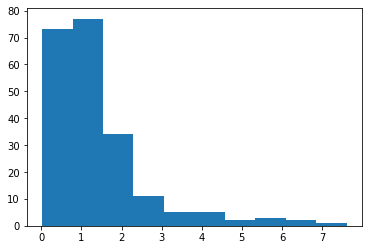

In [291]:
print (Z_points_beg.iloc[-1][0],Z_points_end.iloc[-1][0])
k=Z_points_end.iloc[:][0]-Z_points_beg[:][0]

plt.hist(k)

In [292]:
def make_rear_dyn_whole(position_data, rear_time_beg, rear_time_end ,metadata,in_arena=True):
    '''
    Return
    trial_list: list of numpy arrays position data [time, x, y, z] 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible)
    before_beacon: list of positions before the first beacon appears
    '''

    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time_end.iloc[:, -2:]
    
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_beg_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_beg.iloc[:, 0]
    ]
    rear_time_end_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_end.iloc[:, 0]
    ]

    trial_list.append(position_data[rear_time_beg_idx[0]:rear_time_end_idx[0]])
    for i in range(len(rear_time_end_idx)):
        if i != len(rear_time_end_idx) - 1:
            trial = position_data[
                rear_time_beg_idx[i]:rear_time_end_idx[i]]
        else:
            print('last rear')#trial = position_data[rear_time_beg_idx[i]:]
        trial_list.append(trial)
    #before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=make_rear_dyn_whole(position_data =FS03_position , 
                                                               rear_time_beg=Z_points_beg, rear_time_end=Z_points_end,
                                                                     metadata=FS03_metadata )


last rear


0.40000009536743164


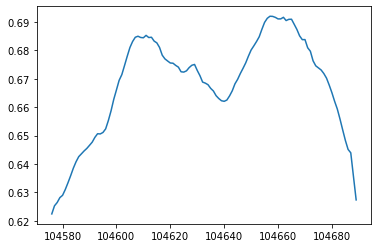

In [294]:
#print(trial_list[2][0][-1])

print (trial_list[2][0].loc[trial_list[2][0].index[-1]] -trial_list[2][0].loc[trial_list[2][0].index[0]] )
plt.plot(trial_list[-1][2]) 

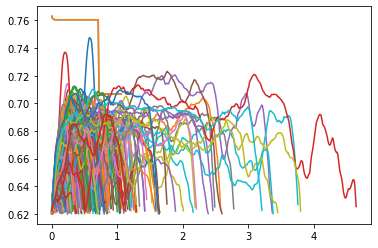

In [295]:
#print (len(trial_list[5]))



#print(trial_list)
for trial in trial_list: 
    #end= (trial[0].loc[trial[0].index[-1]] -trial[0].loc[trial[0].index[0]])
    #beg = 0
    trial_time=range(len(trial[0]))  # runnign into division of small numbers unfortunately to be able to correct the timing 
    time = [i/100 for i in trial_time] 
    plt.plot(time, trial[2],)

### TODO: 
    Make all into a function which takes in position and generates only rearign trajectories 

In [298]:
def Rearing_traj (position_data,metadata,in_arena=True):
    '''
    Return
    trial_list: list of numpy arrays position data [time, x, y, z] 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible)
    before_beacon: list of positions before the first beacon appears
    '''

    
    rear_time_beg,rear_time_end = Z_period_dynamics_beg_end(position_data)
    
    
    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time_end.iloc[:, -2:]
    
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_beg_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_beg.iloc[:, 0]
    ]
    rear_time_end_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time_end.iloc[:, 0]
    ]

    trial_list.append(position_data[rear_time_beg_idx[0]:rear_time_end_idx[0]])
    for i in range(len(rear_time_end_idx)):
        if i != len(rear_time_end_idx) - 1:
            trial = position_data[
                rear_time_beg_idx[i]:rear_time_end_idx[i]]
        else:
            print('last rear')#trial = position_data[rear_time_beg_idx[i]:]
        trial_list.append(trial)
    #before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=Rearing_traj(position_data =FS03_position ,metadata=FS03_metadata )

last rear


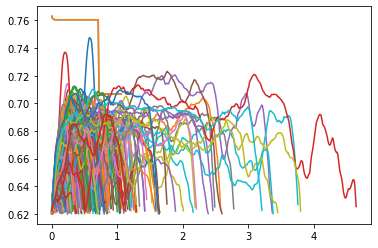

In [299]:
for trial in trial_list: 
    trial_time=range(len(trial[0]))  # runnign into division of small numbers unfortunately to be able to correct the timing 
    time = [i/100 for i in trial_time] 
    plt.plot(time, trial[2],)

# GRAVEYARD

### Calculate how much time per rear period just from the position data

In [146]:
def average_Z_time_period(session_list):
    total = []
    for session in session_list: 
        total.append(Z_periods(session))
    print (total)
    average = statistics.median(total)
    #plt.bar(range(len(total)),total)
    return total

def Z_periods(positions): 
    high =0 
    low = 0
    switch = 0 
    last = .60
    z= positions[2]
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
        last = height
    return high

def Z_time(positions): 
    high =0 
    low=0 
    z= positions[2]
    for height in z: 
        if height >.62:
            high +=1       
    percent =  high/ z.size*100
    return percent




Animals=['//10.153.170.3/storage2/fabian/data/raw/FS03/Event_files_FS03/','//10.153.170.3/storage2/fabian/data/raw/FS04/Event_files_FS04/']
Names = ['FS03','FS04']

def All_new_animals(Animal_names):
    
    
    fig, ax = plt.subplots(dpi= 100)
    
    
    n=2
    for animal_ID in Animal_names:
        n+=1
        height_periods = []
        result=pd.DataFrame()
        for dirpath, dirnames, files in os.walk(animal_ID, topdown=True):
            for metadata in files:
                if fnmatch.fnmatch(metadata, 'position_*'):
                    k=(animal_ID+'/'+metadata)
                    day = pd.read_csv(k,sep=" ", header=None,engine='python')
                    height_periods.append(Z_periods(day))

        X_markers = range(len(height_periods))
        if n==3: 
            ax.bar(X_markers,height_periods, label= '%s' %Names[0],alpha=.5)  
        else:
            ax.bar(X_markers,height_periods, label= '%s' %Names[1],alpha=.5)  
        
    #ax.bar(range(len(list_of_days)),average_Z_time_period(list_of_days),label= 'old FS1',alpha=.2)
    #ax.bar(range(len(list_of_days2)),average_Z_time_period(list_of_days2),label= 'old FS2',alpha=.2)
    ax.set_ylabel('Rears')
    ax.set_xlabel('Session')
    ax.set_title('Rear periods during electrophysiology only')
    
    ax.legend()  
    #ax.set_xticklabels(X_markers)
    plt.savefig(figures+'Number_of_rears_in_highzone_ephys_only.png', dpi = 300)
All_new_animals(Animals) 

Animals=['//10.153.170.3/storage2/fabian/data/raw/FS03/Event_files_FS03/','//10.153.170.3/storage2/fabian/data/raw/FS04/Event_files_FS04/']

Names = ['FS03','FS04']

def All_new_animals_height(Animal_names):   
    
    plt.figure(figsize=(20,20))
    plt.ylim(.4, .8)
    plt.title('Distribution of Heights per sessions - electrophysiology FS03 and FS04')
    plt.ylabel("Animal height")
    
    n=2
    for animal_ID in Animal_names:
        n+=1
        height_time = []
        result=pd.DataFrame()
        for dirpath, dirnames, files in os.walk(animal_ID, topdown=True):
            for metadata in files:
                if fnmatch.fnmatch(metadata, 'position_*'):
                    k=(animal_ID+'/'+metadata)
                    day = pd.read_csv(k,sep=" ", header=None,engine='python')
                    height_time.append(Z_periods(day))
                    sns.distplot(day[2],vertical=True)
                        

    plt.savefig(figures+'FS3_6_Distribution of Heights per sessions_.png', dpi = 200)

All_new_animals_height(Animals) 


 
Animals=['//10.153.170.3/storage2/fabian/data/raw/FS03/Event_files_FS03/','//10.153.170.3/storage2/fabian/data/raw/FS04/Event_files_FS04/']

Names = ['FS03','FS04']

def All_new_animals_height_percent(Animal_names):
    
    fig, ax = plt.subplots(dpi= 300)
    ax.set_ylabel('percent of time in session rearing - electophysiology only')
    ax.set_xlabel('Session')
    ax.set_title('Percent time above .62m')
    
    n=2
    for animal_ID in Animal_names:
        n+=1
        height_time = []
        result=pd.DataFrame()
        for dirpath, dirnames, files in os.walk(animal_ID, topdown=True):
            for metadata in files:
                if fnmatch.fnmatch(metadata, 'position_*'):
                    k=(animal_ID+'/'+metadata)
                    day = pd.read_csv(k,sep=" ", header=None,engine='python')
                    height_time.append(Z_time(day))
        if n==3: 
            ax.plot(height_time, label= '%s' %Names[0]) 
        else:
            ax.plot(height_time, label= '%s' %Names[1]) 
         
    ax.legend() 
    #ax.set_xticklabels(range(len(height_time)))
    plt.savefig(figures+'Percent_time_in_highzone - electophysiology only.png', dpi = 200)
All_new_animals_height_percent(Animals) 
   

In [ ]:
position_data =FS03_position

In [41]:
def get_rear_distance_from_beacon(df_rears_corrected):
    dist=[]
    for row in df_rears_corrected.iterrows():
        #print(row[1][1])
        #print(row[1][4])
        #print(row[1][2])
        #print(row[1][5])
        dist.append(math.sqrt((row[1][1] - row[1][4])**2 + (row[1][2] - row[1][5])**2))

    return dist 
plt.hist(get_rear_distance_from_beacon(rearing))

NameError: name 'rearing' is not defined

In [42]:
def make_rear_dyn(position_data, rear_time ,metadata, window_beg=window_beg,window_end=window_end,in_arena=True):
    '''
    Return
    trial_list: list of numpy arrays position data [time, x, y, z] 
    rear_time: list of rears detected
    trial_visible: list of booleans referring visibility of trial (True - visible, False- invisible
    before_beacon: list of positions before the first beacon appears
    '''

    trial_list = []
    #print(beacon_data.iloc[:, -2:])
    trial_beacon = rear_time.iloc[:, -2:]
    sampling_rate = position_data.iloc[1, 0] - position_data.iloc[0, 0]
    rear_time_idx = [
        np.argmin(abs(position_data.iloc[:, 0] - i)) for i in rear_time.iloc[:, 0]
    ]

    trial_list.append(position_data[:rear_time_idx[0]])
    for i in range(len(rear_time_idx)):
        if i != len(rear_time_idx) - 1:
            trial = position_data[
                rear_time_idx[i]-window_beg:rear_time_idx[i]+window_end]
        else:
            trial = position_data[rear_time_idx[i]:]
        trial_list.append(trial)
    before_beacon = position_data[:rear_time_idx[0]]
    visible = []
    trial_visible = [True] * len(trial_list)
    invisible_time = eval(metadata['invisible_time'].item())
    invisible_index = eval(metadata['invisible_list'].item())

    for n, trial in enumerate(trial_list):
        trial_visible_ = np.ones_like(trial)
        if n in invisible_index:
            time_after = np.cumsum(trial.iloc[1:, 0] - trial.iloc[:-1, 0])
            if time_after.iloc[-1] > invisible_time:
                invisible_end = np.where(time_after >= invisible_time)[0][0]
                trial_visible_ = trial_visible_[:invisible_end]
            trial_visible[n] = False
        visible.append(trial_visible_)

    return trial_list, trial_beacon, visible, trial_visible

trial_list, trial_beacon, visible, trial_visible=make_rear_dyn(position_data =FS03_position , 
                                                               rear_time= Z_points, metadata=FS03_metadata,window_beg=window_beg,window_end=window_end )